# Import the libraries

In [2]:
# Machine learning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

# For Data Manipulation 
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# To ignore warnings 
import warnings
warnings.filterwarnings("ignore")

# Read Nifty50 data

N50 csv file contains nifty50 index 5 min OHLC data
The closing price of the stocks are stored in the csv file. read_csv method of pandas can be used the read csv files.

Syntax:

import pandas as pd
pd.read_csv(filename,index_col)
1. filename: name of the file in the string format
2. index_col: column(s) to use as the row labels of the dataframe, either given as string name or column index

In [3]:
# The data is stored in the NIFTY file
Df = pd.read_csv('N50.csv',index_col=0)

# Convert index to datetime format
Df.index = pd.to_datetime(Df.index)

# Print the first five row
Df

,Time,open,high,low,close
date,,,,,
2015-09-01,09:15,8285.45,8301.30,8285.45,8301.20
2015-09-01,09:20,8300.50,8303.00,8293.25,8301.00
2015-09-01,09:25,8301.65,8302.55,8286.80,8294.15
2015-09-01,09:30,8294.10,8295.75,8280.65,8288.50
2015-09-01,09:35,8289.10,8290.45,8278.00,8283.45
...,...,...,...,...,...
2021-03-25,15:05,14338.40,14349.70,14319.05,14319.05
2021-03-25,15:10,14319.15,14320.25,14274.15,14299.00
2021-03-25,15:15,14298.90,14315.80,14287.55,14299.75


# Visualize the closing price

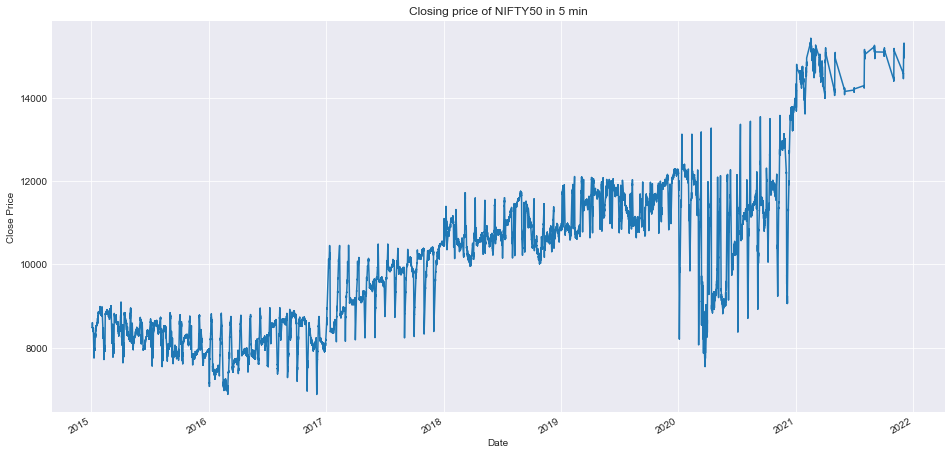

In [4]:
plt.figure(figsize=(16, 8))


Df['close'].plot()
plt.ylabel('Close Price',fontsize=10)
plt.xlabel("Date",fontsize=10)
plt.title("Closing price of NIFTY50 in 5 min")
    
plt.show()

# Defining function to calculate RSI

In [5]:
def rsi(df, periods = 14, ema = True):
    
    close_delta = df['close']-df['open']
    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rs = ma_up / ma_down
    rsi = 100 - (100/(1 + rs))
    return rsi

# Indicator Calculation: Moving Average Convergence Divergnece (MACD)

For the MACD, we will need the close column, so grab that and then apply the transform method along with the specified Lambda function. Now calculating an Exponential Moving Average in pandas is easy. First, call the ewm (exponential moving weight) function and then specify the span or, in other words, the number of periods to look back. In this case, we use the definition provided by the formula and specify 26 & 12.

Once we've calculated the EMA_26 and EMA_12, we take the difference between EMA_12 & EMA_26 to get our MACD. Now that we have our MACD, we need to calculate the EMA of the MACD, so we take our MACD series and apply the same ewm function too, but in this case, we specify a span of 9. Finally, we add both the MACD and MACD_EMA to the main data frame.

In [6]:
# Calculate the MACD
ema_26 = Df['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = Df['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
Df['macd'] = macd
Df['macd_ema'] = ema_9_macd



# Define the explanatory variables

Add moving averages to the data frame

Add BB (Upper and lower) to the data frame

Add RSI to the data frame

In [7]:
Df['open-close']=Df.open-Df.close
Df['high-low']=Df.high-Df.low
Df['sma20']=Df['close'].rolling(window=20).mean()
Df['sma9']=Df['close'].rolling(window=9).mean()
Df['std20']=Df['close'].rolling(window=20).std()
Df['upper']=Df['sma20']+(2*Df['std20'])
Df['lower']=Df['sma20']-(2*Df['std20'])
Df['ratio']=Df['close']/Df['sma20']

Df["rsi"]=rsi(Df)
Df=Df.dropna()
Df

,Time,open,high,low,close,macd,macd_ema,open-close,high-low,sma20,sma9,std20,upper,lower,ratio,rsi
date,,,,,,,,,,,,,,,,
2015-09-01,10:50,8281.95,8285.75,8279.10,8284.65,-0.589990,-0.653139,-2.70,6.65,8286.3525,8285.044444,6.393283,8299.139067,8273.565933,0.999795,49.069460
2015-09-01,10:55,8285.00,8288.20,8282.40,8285.70,-0.470150,-0.616201,-0.70,5.80,8285.5775,8285.505556,5.353663,8296.284825,8274.870175,1.000015,50.050550
2015-09-01,11:00,8285.75,8288.85,8282.30,8288.00,-0.217491,-0.535866,-2.25,6.55,8284.9275,8286.022222,4.000904,8292.929307,8276.925693,1.000371,53.173003
2015-09-01,11:05,8287.95,8288.10,8280.20,8281.55,-0.457164,-0.520032,6.40,7.90,8284.2975,8285.361111,3.422467,8291.142435,8277.452565,0.999668,44.627297
2015-09-01,11:10,8281.85,8286.35,8279.90,8282.35,-0.582919,-0.532669,-0.50,6.45,8283.9900,8284.461111,3.299067,8290.588134,8277.391866,0.999802,45.366042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,15:05,14338.40,14349.70,14319.05,14319.05,6.707557,13.996221,19.35,30.65,14395.5700,14400.516667,39.898930,14475.367859,14315.772141,0.994684,40.149874
2021-03-25,15:10,14319.15,14320.25,14274.15,14299.00,-0.978589,11.001259,20.15,46.10,14394.1625,14392.644444,42.828553,14479.819606,14308.505394,0.993389,37.677401
2021-03-25,15:15,14298.90,14315.80,14287.55,14299.75,-6.929517,7.415104,-0.85,28.25,14390.5550,14381.750000,47.577767,14485.710534,14295.399466,0.993690,37.851265


In [8]:
Df['ratio'].describe()

count    114811.000000
mean          1.000048
std           0.003154
min           0.904804
25%           0.999006
50%           1.000083
75%           1.001151
max           1.085801
Name: ratio, dtype: float64

In [9]:
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(Df['ratio'].dropna(), percentiles)

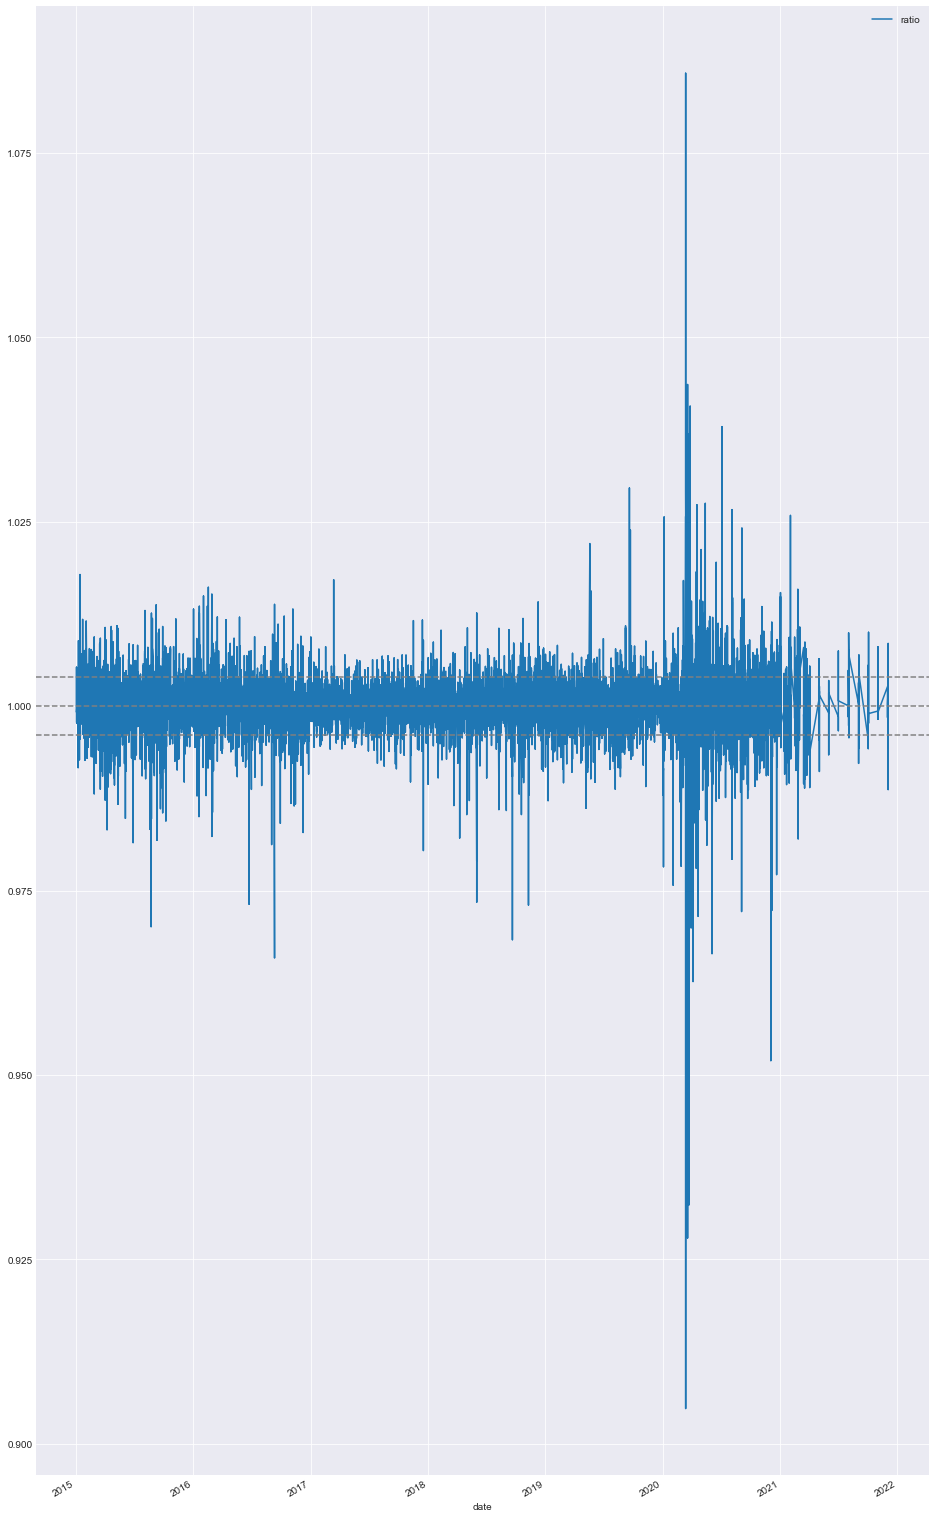

In [10]:
# creating horizontal line to visualize
plt.figure(figsize=(16, 30))
Df['ratio'].dropna().plot(legend = True)

plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');

In [11]:
short = p[-1]
long = p[0]
Df['prediction'] = np.where(Df.ratio > short, -1, np.nan)
Df['prediction'] = np.where(Df.ratio < long, 1, Df['prediction'])
Df['prediction'] = Df['prediction'].ffill()

<AxesSubplot:xlabel='date'>

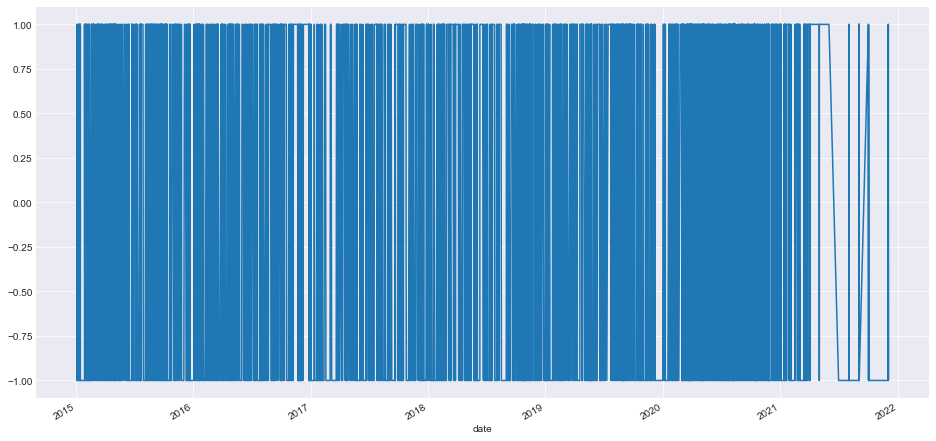

In [12]:
plt.figure(figsize=(16, 8))
Df['prediction'].dropna().plot()

In [13]:
Df.tail(50)

,Time,open,high,low,close,macd,macd_ema,open-close,high-low,sma20,sma9,std20,upper,lower,ratio,rsi,prediction
date,,,,,,,,,,,,,,,,,
2021-03-25,11:20,14371.00,14386.30,14366.75,14385.20,-35.711334,-39.208149,-14.20,19.55,14405.0225,14384.661111,22.787852,14450.598203,14359.446797,0.998624,34.325871,1.0
2021-03-25,11:25,14385.45,14391.25,14374.90,14387.30,-33.469744,-38.060468,-1.85,16.35,14402.7475,14383.011111,22.130501,14447.008502,14358.486498,0.998927,35.161262,1.0
2021-03-25,11:30,14386.55,14388.55,14376.65,14387.10,-31.348046,-36.717983,-0.55,11.90,14401.1825,14381.311111,22.071989,14445.326478,14357.038522,0.999022,35.424252,1.0
2021-03-25,11:35,14387.20,14397.85,14386.85,14389.10,-29.168960,-35.208179,-1.90,11.00,14400.0825,14382.083333,22.099906,14444.282313,14355.882687,0.999237,36.384197,1.0
2021-03-25,11:40,14389.15,14392.35,14380.05,14381.35,-27.747523,-33.716048,7.80,12.30,14397.2425,14380.772222,20.545420,14438.333340,14356.151660,0.998896,34.140460,1.0
2021-03-25,11:45,14381.80,14381.80,14367.85,14380.30,-26.401411,-32.253120,1.50,13.95,14394.0500,14380.922222,17.626333,14429.302667,14358.797333,0.999045,33.709935,1.0
2021-03-25,11:50,14380.70,14386.10,14367.05,14367.05,-26.102874,-31.023071,13.65,19.05,14390.5525,14379.838889,15.462539,14421.477579,14359.627421,0.998367,30.002204,1.0
2021-03-25,11:55,14366.75,14366.75,14349.30,14351.35,-26.823930,-30.183243,15.40,17.45,14387.4625,14377.711111,16.824073,14421.110647,14353.814353,0.997490,26.465468,1.0
2021-03-25,12:00,14351.25,14351.25,14313.90,14317.55,-29.779471,-30.102488,33.70,37.35,14382.7600,14371.811111,22.053533,14426.867066,14338.652934,0.995466,20.711630,1.0


# Building the Model: Removing NaN Values

The random forest can't accept Nan values, so we will need to remove them before feeding the data in. The code below prints the number of rows before dropping the NaN values, use the dropna method to remove any rows NaN values and then displays the number of rows after dropping the NaN values.

In [14]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(Df.shape[0], Df.shape[1]))

# Any row that has a `NaN` value will be dropped.
Df = Df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(Df.shape[0], Df.shape[1]))

# Print the head.
Df.head()

Before NaN Drop we have 114811 rows and 17 columns
After NaN Drop we have 114797 rows and 17 columns


,Time,open,high,low,close,macd,macd_ema,open-close,high-low,sma20,sma9,std20,upper,lower,ratio,rsi,prediction
date,,,,,,,,,,,,,,,,,
2015-09-01,12:00,8259.20,8260.30,8211.20,8211.50,-10.240161,-6.139992,47.70,49.10,8270.3250,8253.050000,19.382388,8309.089776,8231.560224,0.992887,16.054027,1.0
2015-09-01,12:05,8211.15,8226.00,8191.10,8211.85,-12.742776,-7.461085,-0.70,34.90,8266.3950,8246.972222,22.761087,8311.917174,8220.872826,0.993402,16.737905,1.0
2015-09-01,12:10,8211.70,8221.85,8201.30,8221.85,-13.801650,-8.729609,-10.15,20.55,8263.0750,8242.205556,24.202482,8311.479964,8214.670036,0.995011,26.134550,1.0
2015-09-01,12:15,8222.85,8226.90,8208.90,8221.50,-14.497746,-9.883536,1.35,18.00,8259.8275,8238.422222,25.236364,8310.300228,8209.354772,0.995360,25.718803,1.0
2015-09-01,12:20,8221.40,8226.65,8216.75,8219.95,-14.993344,-10.905710,1.45,9.90,8256.7575,8234.872222,26.196732,8309.150964,8204.364036,0.995542,25.254112,1.0


# Building the Model: Splitting the Data

If you remember back to our series on regression analysis, we have split our data into a training set and testing set. For Random Forest, we need to do the same, so we need to identify our input columns which are the following:

RSI

MACD

MACD_EMA

upper (BB)

lower(BB)

open-close

high-low

Those columns will serve as our X, and our Y column will be the Prediction column, the column that specifies whether the stock closed up or down compared to the previous day.

Once we've selected our columns, we need to split the data into a training and test set. SciKit learn makes this easy by providing the train_test_split object, which will take our X_Cols and Y_Cols and split them based on the size we input. In our case, let's have the test_size be '20 %. For reproducibility, thetrain_test_splitobject provides therandom_state` argument that will split the data along the same dimensions every time.

After we've split the data, we can create our RandomForestClassifier model.

Once we've created it, we can fit the training data to the model using the fit method. Finally, with our "trained" model, we can make predictions. Take the X_test data set and use it to make predictions.

In [15]:
# Grab our X & Y Columns.
X_Cols = Df[['rsi','macd','macd_ema','upper','lower','open-close','high-low','sma20','sma9']]
Y_Cols = Df['prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Model Evaluation: Accuracy

We've built our model, so let's see how accurate it is. SciKit learn, again, makes the process of evaluating our model very easy by providing a bunch of built-in metrics that we can call.

One of those metrics is the accuracy_score.

The accuracy_score function computes the accuracy, either the fraction (default) or the count (normalize=False) of correct predictions. Accuracy is defined as the number of accurate predictions the model made on the test set. Imagine we had three TRUE values [1, 2, 3], and our model predicted the following values [1, 2, 4] we would say the accuracy of our model is 66 %.

In [16]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  90.63414634146342


# Interpreting the Classification Report

Now the fun part, interpretation. When it comes to evaluating the model, there we generally look at the accuracy. If our accuracy is high, it means our model is correctly classifying items.

In some cases, we will have models that may have low precision or high recall. It's difficult to compare two models with low precision and high recall or vice versa. To make results comparable, we use a metric called the F-Score. The F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

In [17]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.906178,0.925994,0.915979,15823.000000
Up Day,0.906552,0.882193,0.894207,12877.000000
accuracy,0.906341,0.906341,0.906341,0.906341
macro avg,0.906365,0.904093,0.905093,28700.000000
weighted avg,0.906346,0.906341,0.906210,28700.000000


# Model Evaluation: Confusion Matrix

Accuracy: 0.9063414634146342
Percision: 0.9065517516558934
Recall: 0.8821930573891434
Specificity: 0.9259938064842318


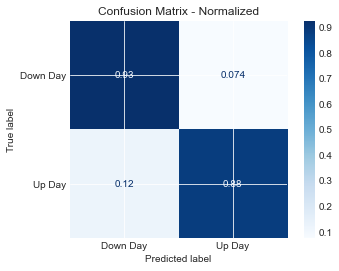

In [18]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

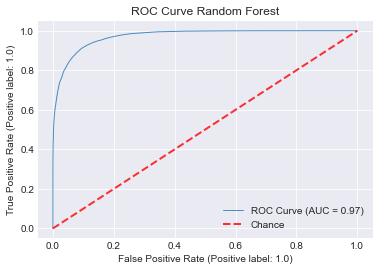

In [19]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

In [20]:
Df

,Time,open,high,low,close,macd,macd_ema,open-close,high-low,sma20,sma9,std20,upper,lower,ratio,rsi,prediction
date,,,,,,,,,,,,,,,,,
2015-09-01,12:00,8259.20,8260.30,8211.20,8211.50,-10.240161,-6.139992,47.70,49.10,8270.3250,8253.050000,19.382388,8309.089776,8231.560224,0.992887,16.054027,1.0
2015-09-01,12:05,8211.15,8226.00,8191.10,8211.85,-12.742776,-7.461085,-0.70,34.90,8266.3950,8246.972222,22.761087,8311.917174,8220.872826,0.993402,16.737905,1.0
2015-09-01,12:10,8211.70,8221.85,8201.30,8221.85,-13.801650,-8.729609,-10.15,20.55,8263.0750,8242.205556,24.202482,8311.479964,8214.670036,0.995011,26.134550,1.0
2015-09-01,12:15,8222.85,8226.90,8208.90,8221.50,-14.497746,-9.883536,1.35,18.00,8259.8275,8238.422222,25.236364,8310.300228,8209.354772,0.995360,25.718803,1.0
2015-09-01,12:20,8221.40,8226.65,8216.75,8219.95,-14.993344,-10.905710,1.45,9.90,8256.7575,8234.872222,26.196732,8309.150964,8204.364036,0.995542,25.254112,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,15:05,14338.40,14349.70,14319.05,14319.05,6.707557,13.996221,19.35,30.65,14395.5700,14400.516667,39.898930,14475.367859,14315.772141,0.994684,40.149874,1.0
2021-03-25,15:10,14319.15,14320.25,14274.15,14299.00,-0.978589,11.001259,20.15,46.10,14394.1625,14392.644444,42.828553,14479.819606,14308.505394,0.993389,37.677401,1.0
2021-03-25,15:15,14298.90,14315.80,14287.55,14299.75,-6.929517,7.415104,-0.85,28.25,14390.5550,14381.750000,47.577767,14485.710534,14295.399466,0.993690,37.851265,1.0


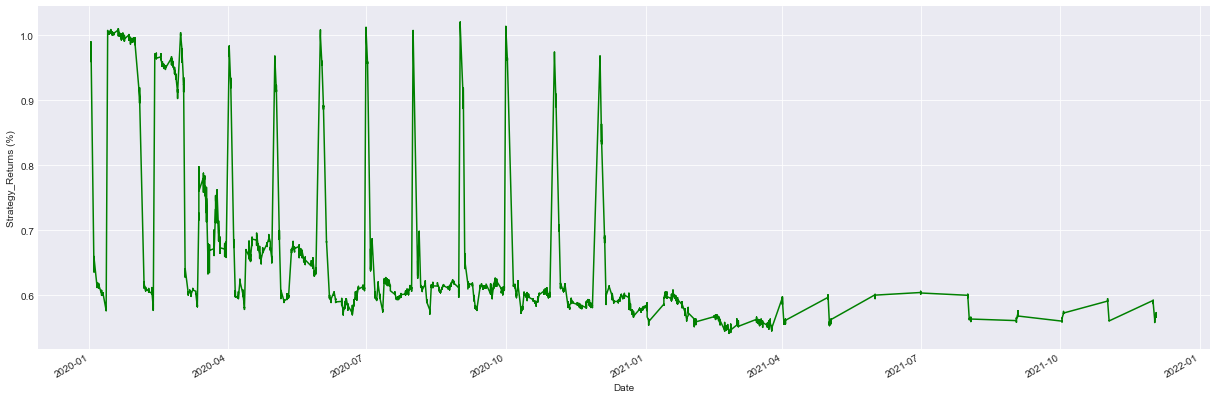

In [26]:
# Calculate daily returns
Df['Return']=Df.close.pct_change()

# Calculate strategy returns
Df['Strategy_Return']=Df.Return * Df.prediction.shift(1)

# Calculate geometric returns
geometric_returns=(Df.Strategy_Return.iloc[split:]+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(21,7),color='g')
plt.ylabel("Strategy_Returns (%)")
plt.xlabel("Date")
plt.show()